# Alexnet Model

Make a model based on the architecture of AlexNet


## Importing Moduels

In [1]:
import torch
import numpy as np
from torch import nn,optim
from torch.nn import functional as F
import matplotlib.pyplot as plt
%matplotlib inline

# CUDA_LAUNCH_BLOCKING=1

In [2]:
device = torch.cuda.is_available()

# Checking CUDA 
if device: print('CUDA available. Training on GPU')
else: print("CUDA is not available. Training on CPU")

CUDA available. Training on GPU


##Importing Datset from Kaggle


In [3]:
!pip install kaggle

In [5]:
# ! kaggle competitions download -c 'name-of-competition'
# !kaggle datasets download -d gpiosenka/100-bird-species
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"fahad30","key":"4e91a2106da274d010c655bed6597d00"}'}

In [6]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
# ! kaggle datasets list
!kaggle datasets download -d gpiosenka/100-bird-species
# ! kaggle datasets download -d gpiosenka/100-bird-species



100% 1.80G/1.81G [00:16<00:00, 68.3MB/s]
100% 1.81G/1.81G [00:16<00:00, 117MB/s] 


In [7]:
!mkdir data
!unzip 100-bird-species.zip -d data


Streaming output truncated to the last 5000 lines.
  inflating: data/birds_rev2/train/TOWNSENDS WARBLER/091.jpg  
  inflating: data/birds_rev2/train/TOWNSENDS WARBLER/092.jpg  
  inflating: data/birds_rev2/train/TOWNSENDS WARBLER/093.jpg  
  inflating: data/birds_rev2/train/TOWNSENDS WARBLER/094.jpg  
  inflating: data/birds_rev2/train/TOWNSENDS WARBLER/095.jpg  
  inflating: data/birds_rev2/train/TOWNSENDS WARBLER/096.jpg  
  inflating: data/birds_rev2/train/TOWNSENDS WARBLER/097.jpg  
  inflating: data/birds_rev2/train/TOWNSENDS WARBLER/098.jpg  
  inflating: data/birds_rev2/train/TOWNSENDS WARBLER/099.jpg  
  inflating: data/birds_rev2/train/TOWNSENDS WARBLER/100.jpg  
  inflating: data/birds_rev2/train/TOWNSENDS WARBLER/101.jpg  
  inflating: data/birds_rev2/train/TOWNSENDS WARBLER/102.jpg  
  inflating: data/birds_rev2/train/TOWNSENDS WARBLER/103.jpg  
  inflating: data/birds_rev2/train/TOWNSENDS WARBLER/104.jpg  
  inflating: data/birds_rev2/train/TOWNSENDS WARBLER/105.jpg  
  in

## Creating Datasets

In [4]:
from torchvision import datasets
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
# from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader


batch_size = 32


transform = transforms.Compose([
                                transforms.Resize((227,227)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
                                ])

data_dir ='data/birds'


train_data = ImageFolder(data_dir+'/train',transform = transform)
valid_data = ImageFolder(data_dir+'/valid',transform = transform)
test_data = ImageFolder(data_dir+'/test',transform = transform)


In [5]:
# Making loaders for the dataset


train_loader = DataLoader(dataset=train_data,batch_size = batch_size, num_workers=0,shuffle = True )
valid_loader = DataLoader(dataset=valid_data,batch_size = batch_size, num_workers=0 ,shuffle = True)
test_loader = DataLoader(dataset=test_data,batch_size = batch_size, num_workers=0 ,shuffle = True)


#Classes of CIFAR10 dataset
# classes = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']

In [6]:
import os

classes = os.listdir("data/birds/train")
classes.sort()
classes
len(classes)
torch.cuda

<module 'torch.cuda' from '/usr/local/lib/python3.7/dist-packages/torch/cuda/__init__.py'>

## Image Visualisation

In [33]:
def imshow(img):
    # img = img.numpy()
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0))) 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(272)

torch.Size([32, 3, 227, 227])

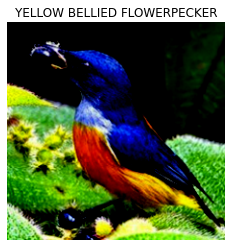

In [35]:
dataiter = iter(train_loader)
images,labels = next(dataiter)

images.numpy()
imshow(images[0])
display(labels[0])
plt.title(classes[labels[0]])
plt.axis('off')


images.shape

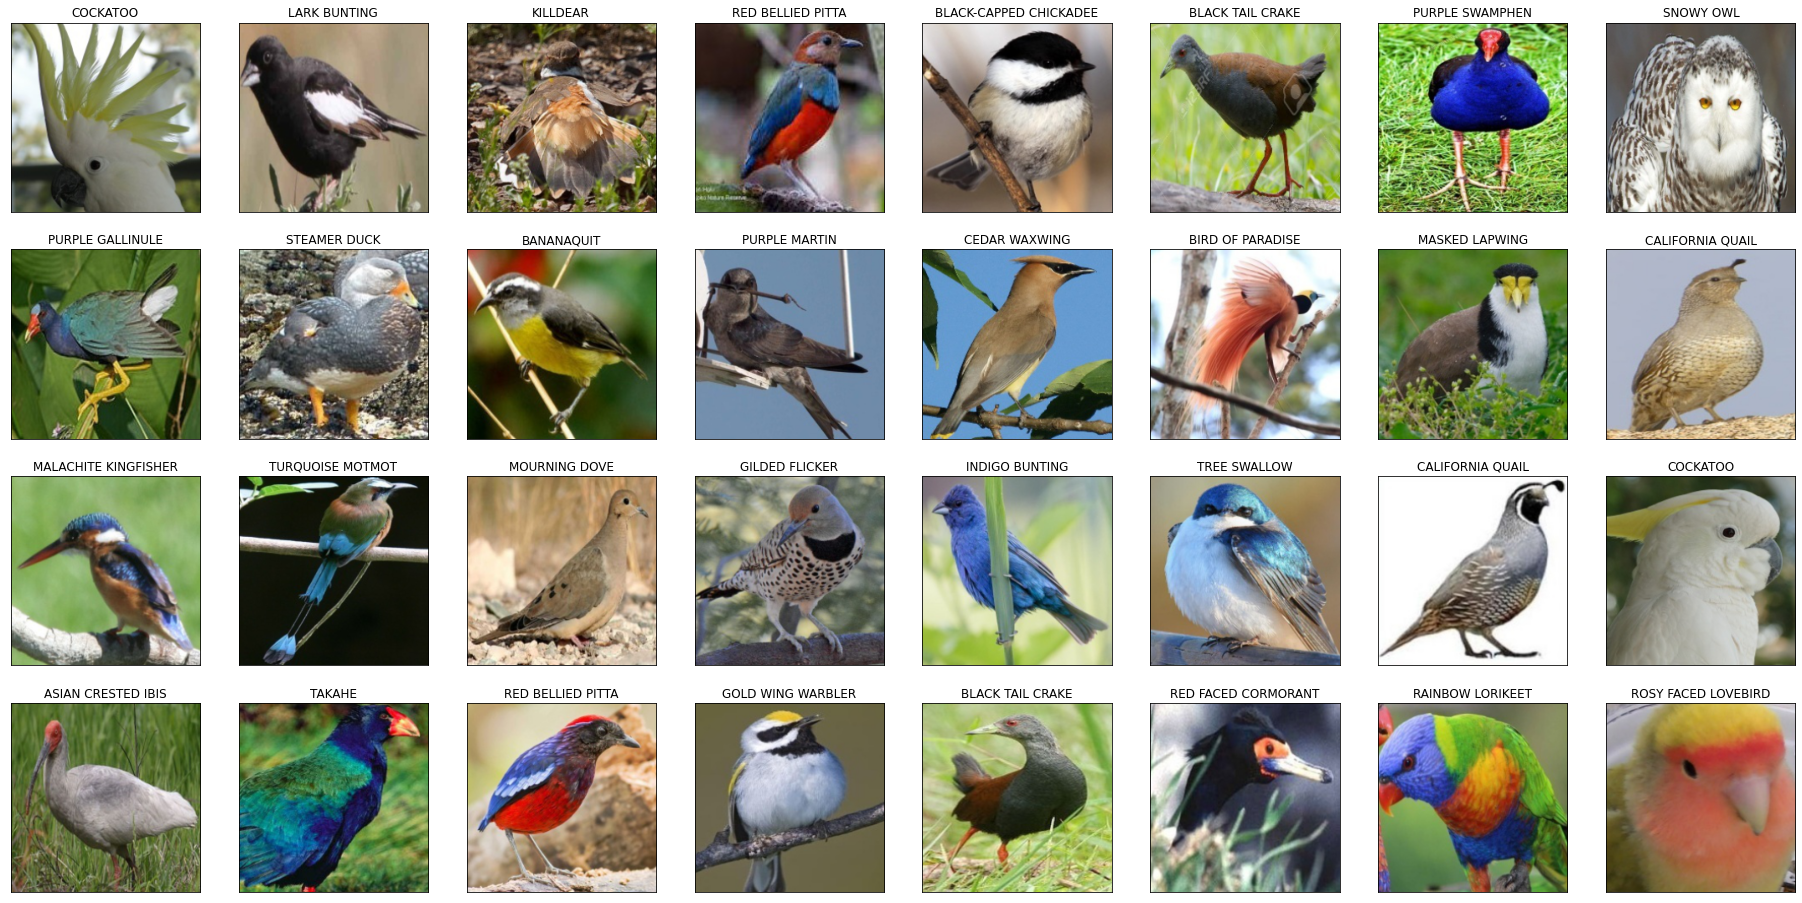

In [11]:
dataiter = iter(train_loader)
images , labels = dataiter.next()

fig = plt.figure(figsize = (32,16))
for i in range(batch_size):
    sub = fig.add_subplot(4,8,i+1,xticks=[],yticks = [])
    sub.set_title(classes[labels[i]])
    imshow(images[i])

## AlexNet Model Architecture


This is the [AlexNet Architecture](https://www.analyticsvidhya.com/blog/2021/03/introduction-to-the-architecture-of-alexnet/) in table form.:


Convolutional Layers
![](https://cdn.analyticsvidhya.com/wp-content/uploads/2021/03/Screenshot-from-2021-03-19-16-01-03.png)

Dropout and Fully Connected Layers
![](https://cdn.analyticsvidhya.com/wp-content/uploads/2021/03/Screenshot-from-2021-03-19-16-01-13.png)

Last 2 fully connected layers are modified. As the general architecture of AlexNet gives us an output of 1000 classification layers, but CIFAR10 has only 10 classes, so I have modified the layers accordingly:

---

> Last 2 Layers


*  FC2 (Fully Connected 2 Layer) has (input, output) ➡ (4096,500)

*  FC3 (Fully Connected 3 Layer) has (input, output) ➡ (500,10)
---

So the final architecture is as follows:

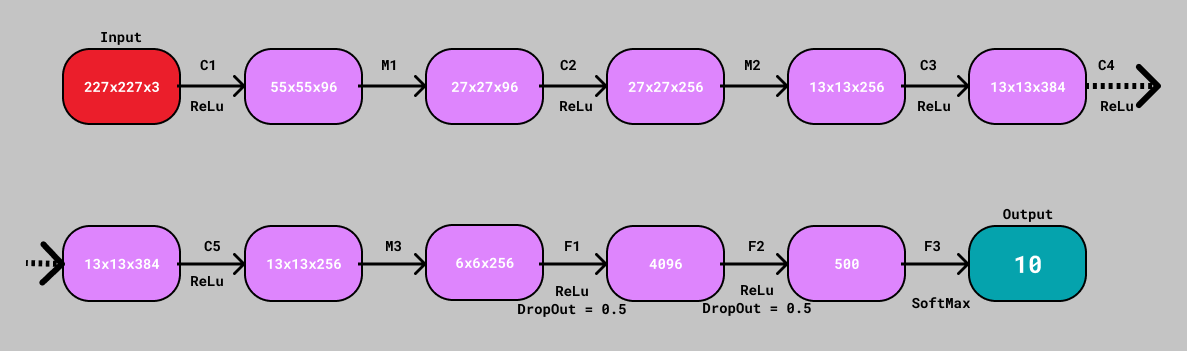


The following layers arguments can be seen in the code. For example you can see the number of filters and kernel size of C1 in the code cell below. I did not find any space in the flowchart above to fit data of each layer. But they do have what is the activation and dropout for each layers.

I have written Last Layer to have activation of Softmax, but I didn't apply any as, my criterion is [nn.CrossEntopyLoss()](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html), which applies log softmax function and nllloss to the last layer. You can find more about Cross Entropy Loss, in the link for the documentation above.

In [12]:
#Adjusting last layers to give output 10 classifications

class AlexNet(nn.Module):
  def __init__(self):
    super(AlexNet,self).__init__()
    self.C1 = nn.Conv2d(3,96,kernel_size= 11, stride= 4)
    self.M1 = nn.MaxPool2d(kernel_size=3,stride=2)
    self.C2 = nn.Conv2d(96,256,kernel_size = 5, stride = 1, padding =2)
    self.M2 = nn.MaxPool2d(kernel_size = 3,stride = 2)
    self.C3 = nn.Conv2d(256,384,kernel_size = 3,stride =1,padding=1)
    self.C4 = nn.Conv2d(384,384,kernel_size = 3,stride =1,padding=1)
    self.C5 = nn.Conv2d(384,256,kernel_size = 3,stride =1,padding=1)
    self.M3 = nn.MaxPool2d(kernel_size = 3,stride = 2)
    self.drop = nn.Dropout( p = 0.5)
    self.F1 = nn.Linear(6*6*256,4096)
    self.F2 = nn.Linear(4096,500)
    self.F3 = nn.Linear(500,275)

  def forward(self,x):
    x = F.relu(self.C1(x))
    x = self.M1(x)
    x = F.relu(self.C2(x))
    x = self.M2(x)
    x = F.relu(self.C3(x))
    x = F.relu(self.C4(x))
    x = F.relu(self.C5(x))
    x = self.M3(x)
    x = torch.flatten(x,1)
    x = self.drop(x)
    x = F.relu(self.F1(x))
    x = self.drop(x)
    x = F.relu(self.F2(x))
    x = self.F3(x)
    x = F.log_softmax(x,dim=1)

    return x

model = AlexNet()

if device:
  model.cuda()

print(model)


AlexNet(
  (C1): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4))
  (M1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (C2): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (M2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (C3): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (C4): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (C5): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (M3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop): Dropout(p=0.5, inplace=False)
  (F1): Linear(in_features=9216, out_features=4096, bias=True)
  (F2): Linear(in_features=4096, out_features=500, bias=True)
  (F3): Linear(in_features=500, out_features=275, bias=True)
)


## Training, Criterion and Optimizer

In [13]:
crit = nn.NLLLoss()
opt = optim.SGD(model.parameters(),lr = 0.01)
images = images.cuda()


model(images).shape
# images.to(torch.device("cuda"))

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


torch.Size([32, 275])

In [16]:
epochs = 20

valid_min_loss = np.Inf

if device:
    print("Training In CUDA")
else:
    print("Training In CPU")

for e in range(epochs):
    model.train()
    train_loss = 0.0
    valid_loss = 0.0

    for images, labels in train_loader:
        if device:
            images = images.cuda()
            labels = labels.cuda()
        opt.zero_grad()

        out = model(images)

        loss = crit(out,labels)

        loss.backward() 

        opt.step()

        train_loss += loss.item()*images.size(0)

    
    model.eval()

    for images,labels in valid_loader:
        if device:
            images,labels = images.cuda(),labels.cuda()

        out = model(images)

        loss = crit(out,labels)

        valid_loss += loss.item()*images.size(0)

    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(valid_loader.dataset)

    print("Epoch{} \t Training Loss: {:0.6f} \t Validation Loss: {:0.6f}".format(e+1,train_loss,valid_loss))

    if valid_loss <= valid_min_loss:
        print("Validation Loss Decreased \t {:0.6f} ---> {:0.6f} \t Saving Model....".format(
            valid_min_loss, valid_loss
        ))
        torch.save(model.state_dict(),'AlexNet.pt')
        valid_min_loss = valid_loss


Training In CUDA


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch1 	 Training Loss: 5.616080 	 Validation Loss: 5.617106
Validation Loss Decreased 	 inf ---> 5.617106 	 Saving Model....
Epoch2 	 Training Loss: 5.614375 	 Validation Loss: 5.617155
Epoch3 	 Training Loss: 5.612707 	 Validation Loss: 5.617279
Epoch4 	 Training Loss: 5.610237 	 Validation Loss: 5.618133
Epoch5 	 Training Loss: 5.604604 	 Validation Loss: 5.619981
Epoch6 	 Training Loss: 5.558664 	 Validation Loss: 5.465589
Validation Loss Decreased 	 5.617106 ---> 5.465589 	 Saving Model....
Epoch7 	 Training Loss: 5.375980 	 Validation Loss: 5.258284
Validation Loss Decreased 	 5.465589 ---> 5.258284 	 Saving Model....
Epoch8 	 Training Loss: 5.104524 	 Validation Loss: 5.293270
Epoch9 	 Training Loss: 4.725254 	 Validation Loss: 4.551591
Validation Loss Decreased 	 5.258284 ---> 4.551591 	 Saving Model....
Epoch10 	 Training Loss: 4.338846 	 Validation Loss: 4.152031
Validation Loss Decreased 	 4.551591 ---> 4.152031 	 Saving Model....
Epoch11 	 Training Loss: 3.916169 	 Validati

**Loading the best Model, with minimum validation loss.**

In [14]:
model.load_state_dict(torch.load('AlexNet.pt'))



<All keys matched successfully>

In [15]:
out = model(images)
out = torch.exp(out)
out = out.to(torch.device('cpu'))
# display(out[1])

_,pred =torch.max(out,1)
display(pred)
# display(pred)

labels[1].data

correct_tensor = pred.eq(labels.data.view_as(pred))

correct = np.squeeze(correct_tensor.numpy()) if not device else np.squeeze(correct_tensor.cpu().numpy())

labels.shape

tensor([ 67,  96,  89, 203,  38,  34, 235, 232, 195, 239, 272, 196,  60,  29,
        172, 190, 272, 255, 163, 105, 235, 235,  53,  67,  15, 234, 203, 108,
         34, 211, 200, 226])

torch.Size([32])

## Testing the Model, and **ACCURACY**

In [16]:
# # # Accuracy
model.eval()
class_correct = list(0. for i in range(275))
class_total = list(0. for i in range(275))

test_loss = 0.0
for images,labels in test_loader:
    if device:
        images,labels = images.cuda(),labels.cuda()
    out = model(images)
    loss = crit(out,labels)

    test_loss += loss.item() * images.size(0)


    _,pred = torch.max(out,1)

    correct_tensor = pred.eq(labels.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not device else np.squeeze(correct_tensor.cpu().numpy())

    for i in range(batch_size-1):
        tar = labels[i].data

        class_correct[tar] += correct[i].item()
        class_total[tar] += 1

test_loss /= len(test_loader.dataset)
print("Test Loss: {:0.6f}".format(test_loss))

for i in range(275):
    if class_total[i] > 0:
        print("Test Accuracy of {}: {}% \t ({}/{})".format(
            classes[i], 100* class_correct[i]/class_total[i],np.sum(class_correct[i]),np.sum(class_total[i])
        ))

    else:
        print("Test Accuracy of {}: N/A (Not Available)".format(classes[i]))
    

print("\n Average Test Accuracy: {}% \t ({}/{})".format(
    100*np.sum(class_correct)/np.sum(class_total),np.sum(class_correct),np.sum(class_total)
))



Test Loss: 1.634356
Test Accuracy of AFRICAN CROWNED CRANE: 40.0% 	 (2.0/5.0)
Test Accuracy of AFRICAN FIREFINCH: 60.0% 	 (3.0/5.0)
Test Accuracy of ALBATROSS: 40.0% 	 (2.0/5.0)
Test Accuracy of ALEXANDRINE PARAKEET: 80.0% 	 (4.0/5.0)
Test Accuracy of AMERICAN AVOCET: 80.0% 	 (4.0/5.0)
Test Accuracy of AMERICAN BITTERN: 80.0% 	 (4.0/5.0)
Test Accuracy of AMERICAN COOT: 60.0% 	 (3.0/5.0)
Test Accuracy of AMERICAN GOLDFINCH: 20.0% 	 (1.0/5.0)
Test Accuracy of AMERICAN KESTREL: 40.0% 	 (2.0/5.0)
Test Accuracy of AMERICAN PIPIT: 80.0% 	 (4.0/5.0)
Test Accuracy of AMERICAN REDSTART: 40.0% 	 (2.0/5.0)
Test Accuracy of ANHINGA: 80.0% 	 (4.0/5.0)
Test Accuracy of ANNAS HUMMINGBIRD: 100.0% 	 (5.0/5.0)
Test Accuracy of ANTBIRD: 50.0% 	 (2.0/4.0)
Test Accuracy of ARARIPE MANAKIN: 100.0% 	 (5.0/5.0)
Test Accuracy of ASIAN CRESTED IBIS: 66.66666666666667% 	 (2.0/3.0)
Test Accuracy of BALD EAGLE: 80.0% 	 (4.0/5.0)
Test Accuracy of BALI STARLING: 80.0% 	 (4.0/5.0)
Test Accuracy of BALTIMORE ORIOLE: 2

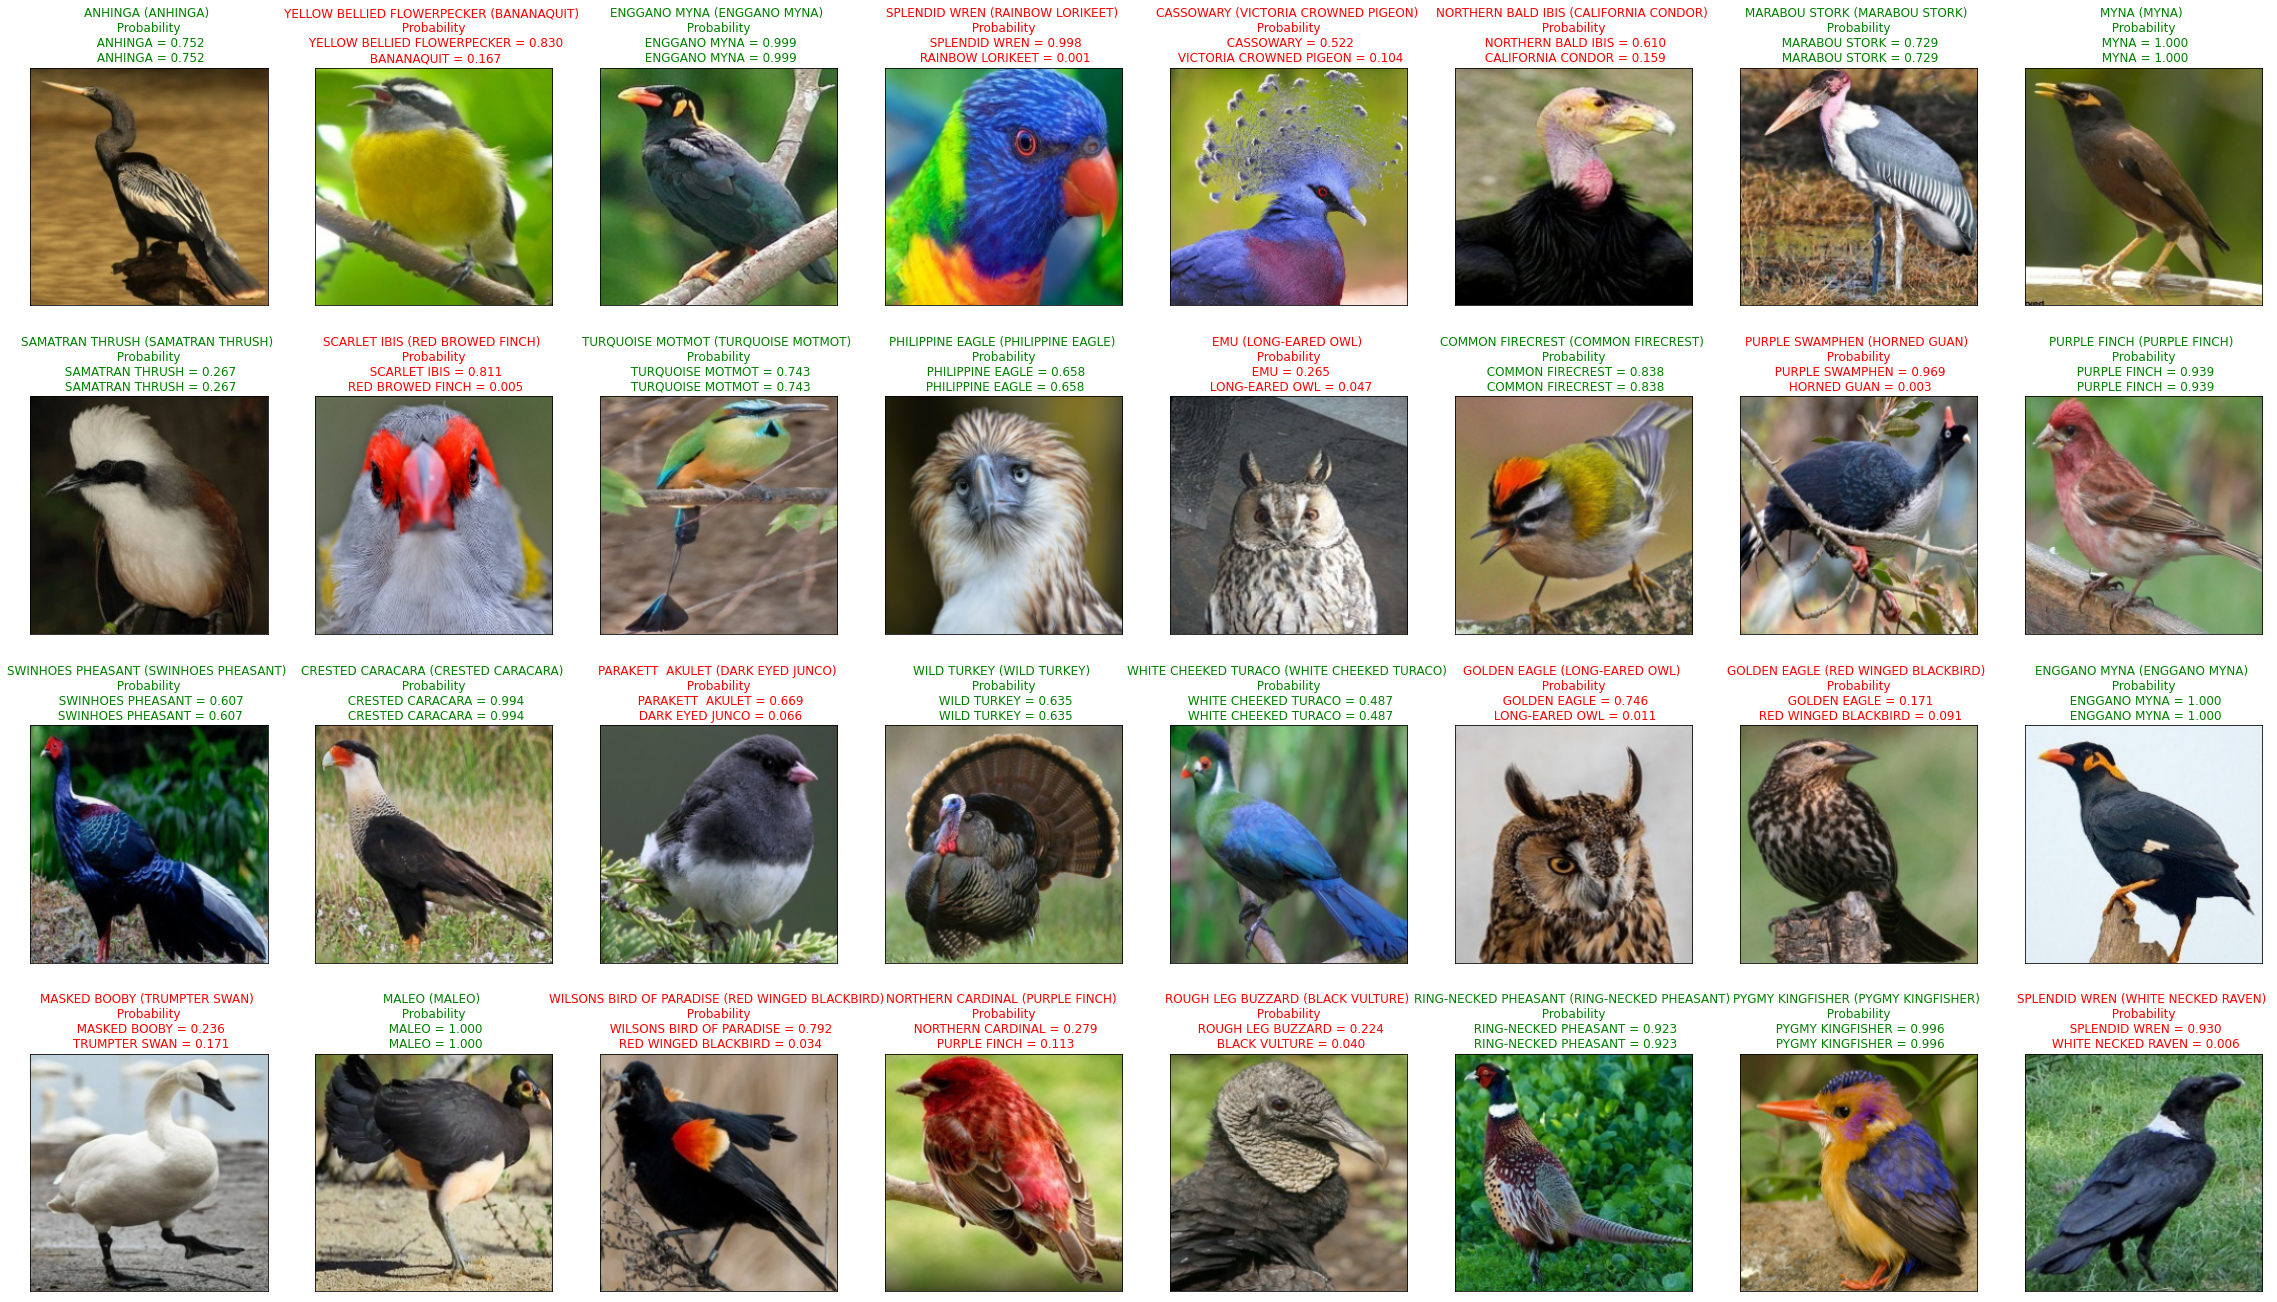

In [17]:
test_iter = iter(test_loader)

images,labels = test_iter.next()
# images = images.numpy()
model.eval()
# display(images)
images.numpy()
if device:
    images = images.cuda()

# display(images.cpu())
out = model(images)
out = torch.exp(out)
pred_value, pred = torch.max(out,1)
# display(pred)

fig = plt.figure(figsize = [40,20])
fig.tight_layout()
plt.subplots_adjust(top=1)
# plt.title("Hello",fontsize=20)
for i in range(batch_size):
    ax = fig.add_subplot(4,8,i+1,xticks=[],yticks=[])
    imshow(images[i] if not device else images[i].cpu())


    ax.set_title("{} ({}) \n Probability \n  {} = {:0.3f} \n {} = {:0.3f}".format(classes[pred[i]],classes[labels[i]],classes[pred[i]],pred_value[i],classes[labels[i]],out[i][labels[i]]),
                    color = ("green" if pred[i] == labels[i].item() else "red"))

In [18]:
from torchsummary import summary

summary(model,(3,227,227))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 96, 55, 55]          34,944
         MaxPool2d-2           [-1, 96, 27, 27]               0
            Conv2d-3          [-1, 256, 27, 27]         614,656
         MaxPool2d-4          [-1, 256, 13, 13]               0
            Conv2d-5          [-1, 384, 13, 13]         885,120
            Conv2d-6          [-1, 384, 13, 13]       1,327,488
            Conv2d-7          [-1, 256, 13, 13]         884,992
         MaxPool2d-8            [-1, 256, 6, 6]               0
           Dropout-9                 [-1, 9216]               0
           Linear-10                 [-1, 4096]      37,752,832
          Dropout-11                 [-1, 4096]               0
           Linear-12                  [-1, 500]       2,048,500
           Linear-13                  [-1, 275]         137,775
Total params: 43,686,307
Trainable para

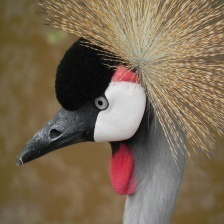

'AFRICAN CROWNED CRANE'

prob_model = 0.8376995921


In [47]:
# br = 'data/birds_rev2/'

# rev2Set = ImageFolder(br+'one',transform=transform)

from PIL import Image
from torchvision.transforms import ToTensor
from torch.autograd import Variable

img_path="/content/data/birds_rev2/one_image_to_test/one/1.jpg"
oneImage = Image.open(img_path)
display(oneImage)

oneImage = transform(oneImage)

oneImage = oneImage.cuda()
oneImage = oneImage.unsqueeze(0)
# oneImage.shape

outOneImg = model(oneImage)

outOneImg = torch.exp(outOneImg)

pred_value,pred = torch.max(outOneImg,1)


display(classes[pred])
print("prob_model = {:0.10f}".format(pred_value[0]))

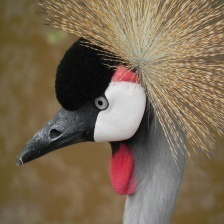

AFRICAN CROWNED CRANE 
 probability : 0.8376995921134949


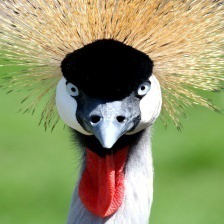

RED HONEY CREEPER 
 probability : 0.5757837295532227


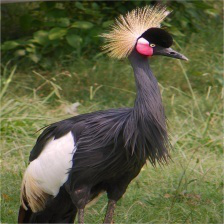

BLACK SWAN 
 probability : 0.454402357339859


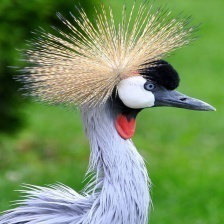

AFRICAN CROWNED CRANE 
 probability : 0.9467307925224304


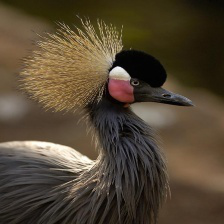

EMU 
 probability : 0.14246031641960144


In [50]:
for i in range(5):
    img_path  = "/content/data/birds_rev2/images to test/{}.jpg".format(i+1)
    testImg = Image.open(img_path)
    display(testImg)
    testImg = transform(testImg)

    if device:
        testImg = testImg.cuda()
    testImg = testImg.unsqueeze(0)

    outTest = model(testImg)
    outTest = torch.exp(outTest)

    pred_value,pred = torch.max(outTest,1)

    print("{} \n probability : {}".format(classes[pred],pred_value[0]))
